In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from progressbar import progressbar as pbar

In [2]:
def grid_cell(df):
    '''Returns the cell of the geographical grid for each row in the dataframe.'''

    # Compute all pair-wise distances. Needed to find the average distance to a neighbor (exluding duplicates).
    _center = df[df['distance'] == 0][['lonm', 'latm']].values[0]
    df[['lonm', 'latm']] -= _center
    X = df[['lonm', 'latm']].values  # coordinates

    # Compute distance matrix
    XXt = X@X.T
    L2 = np.diag(XXt)[:, None]  # vector of squared lengths
    D = np.sqrt(L2 + L2.T - 2*XXt)  # distance matrix
    D_triu = np.triu(D)

    # histogram of distances
    counts, bin_edges = np.histogram(D_triu[(400 > D_triu) & (D_triu > 0)], bins=400);
    i_bin = np.nonzero(counts > 500)[0][0]
    dist_nb = bin_edges[i_bin:i_bin + 2].mean()

    # dist_nb = 153.48
    bin_edges_square = np.arange(-13.5, 14.5, 1) * dist_nb
    ixbin = np.digitize(X[:,0], bin_edges_square) - 1
    iybin = np.digitize(X[:,1], bin_edges_square) - 1

    return list(zip(ixbin, iybin))

In [3]:
def empty_row(z, grid_cell):
    _row = z.iloc[z.shape[0]-1].copy()
    _row['chipid'] = ''
    _row['lonm'] = 0
    _row['latm'] = 0
    _row['embeddings'] = np.zeros(768)
    _row['distance'] = 0
    _row['grid_cell'] = grid_cell
    _row['uniform_norm'] = max(abs(grid_cell[0]-13), abs(grid_cell[1]-13))
    return _row

In [4]:
# inspect and visualize the neighbours of a chip

folder = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours"
files = os.listdir(folder)
file = np.random.choice(files)
print(file)
z = pd.read_parquet(f"{folder}/{file}")

ca_m_3411617_sw_11_060_20220514-4-4.parquet


Storing /opt/data/california-naip-chips/california-naip-chips-100k-neighbours/ca_m_3411617_sw_11_060_20220514-4-4.grid.parquet...
Storing /opt/data/california-naip-chips/california-naip-chips-100k-neighbours/ca_m_3411617_sw_11_060_20220514-4-4.npy...


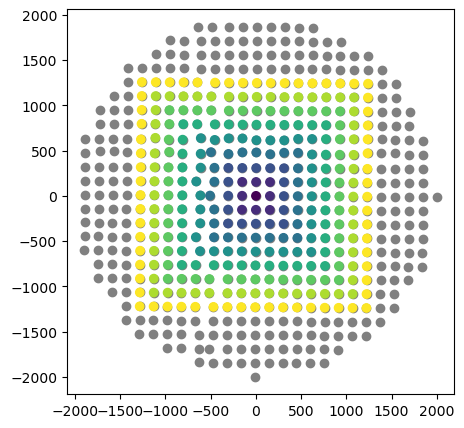

In [5]:
z = pd.read_parquet(f"{folder}/{file}")
z['grid_cell'] = grid_cell(z)
z.sort_values('grid_cell', inplace=True)
z['uniform_norm'] = z['grid_cell'].map(lambda x: max(abs(x[0]-13), abs(x[1]-13)))

# Store DF with grid data
_f = f'{folder}/{file.split('.')[0]}.grid.parquet'
print(f'Storing {_f}...')
# z.to_parquet(_f)

z_dedup = z.drop_duplicates(subset='grid_cell')

R = 8  # Slice chips within the square of radius R
_z = z_dedup.query(f'uniform_norm <= {R}').copy()  # slice chips within the square of radius 8b
if _z.shape[0] != (2*R + 1)**2:
    print((_z.shape[0], (2*R + 1)**2))
else:
    E = np.stack(_z.embeddings.values)
    X = E.reshape((2*R + 1, 2*R + 1, -1))
    _f = f'{folder}/{file.split('.')[0]}.npy'
    print(f'Storing {_f}...')
    # np.save(file=_f, arr=X)

plt.figure(figsize=(5,5)); plt.scatter(z_dedup.lonm, z_dedup.latm, c='gray'); plt.scatter(_z.lonm, _z.latm, c=_z['uniform_norm']);

---

In [8]:
bad_files = []
_r = np.arange(-R, R + 1)
ix_in_square = [(13 + i, 13 + j) for i in _r for j in _r]

for f in pbar(files):

    if not os.path.isfile(f"{folder}/{f}"):
        continue
    z = pd.read_parquet(f"{folder}/{f}")
    z['grid_cell'] = grid_cell(z)
    z.sort_values('grid_cell', inplace=True)
    z['uniform_norm'] = z['grid_cell'].map(lambda x: max(abs(x[0]-13), abs(x[1]-13)))

    # Store DF with grid data
    _f = f'{folder}/grid/{f.split('.')[0]}.grid.parquet'
    # print(f'Saving {_f}...')
    z.to_parquet(_f)

    z_dedup = z.drop_duplicates(subset='grid_cell')

    R = 8  # Slice chips within the square of radius R
    _z = z_dedup.query(f'uniform_norm <= {R}').copy()  # slice chips within the square of radius 8b
    if _z.shape[0] != (2*R + 1)**2:
        bad_files.append(f)
        missing_cells = [ix_in_square[i] for i in np.nonzero(~pd.Index(ix_in_square).isin(_z['grid_cell']))[0]]
        for _m in missing_cells:
            _z.loc[_z.index.max()+1] = empty_row(_z, _m)
        assert _z.shape[0] == 289
    
    E = np.stack(_z.embeddings.values)
    X = E.reshape((2*R + 1, 2*R + 1, -1))
    _f = f'{folder}/npy/{f.split('.')[0]}.npy'
    # print(f'Saving {_f}...')
    np.save(file=_f, arr=X)

100% (104232 of 104232) |################| Elapsed Time: 2:33:19 Time:  2:33:191529


### Validate stored files

In [36]:
folder_grid = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours/grid"
folder_npy = "/opt/data/california-naip-chips/california-naip-chips-100k-neighbours/npy"
file_grid = np.random.choice(os.listdir(folder_grid))
file_npy = np.random.choice(os.listdir(folder_npy))
df = pd.read_parquet(f"{folder_grid}/{file_grid}")
print(file_grid)
x = np.load(f"{folder_npy}/{file_npy}")
print(file_npy, x.shape)

ca_m_3311716_se_11_060_20220415-29-39.grid.parquet
ca_m_3411758_sw_11_060_20220425-29-11.npy (17, 17, 768)


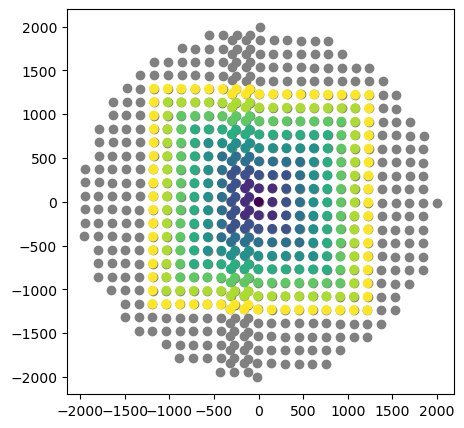

In [35]:
_z = df.query('uniform_norm <= 8').drop_duplicates(subset='grid_cell')
plt.figure(figsize=(5,5)); plt.scatter(df.lonm, df.latm, c='gray'); plt.scatter(_z.lonm, _z.latm, c=_z['uniform_norm']);